# Bitcoin LSTM using Price, Volatility, Volume

## 1. Imports

In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time 

# library for sampling
from scipy.stats import uniform

# libraries for Data Download
import datetime
from pandas_datareader import data as pdr
import yfinance as yf

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Keras
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
     

## 2. Data

In [53]:
# Create bitcoin technical analysis dataframe
ta_df = pd.read_csv('bitcoin-ta-2015.csv')
ta_df['Timestamp'] = pd.to_datetime(ta_df['Timestamp'])

# Create a new column with tomorrow's prices
#ta_df['Close_next_day'] = ta_df['Close'].shift(-1)

# Create a new column which is 1 if the price increases tomorrow, and 0 otherwise
#ta_df['Direction'] = (ta_df['Close_next_day'] > ta_df['Close']).astype(int)

#ta_df.dropna(subset=['Close_next_day', 'Direction'], inplace=True)

# Show rows and columns
print("Rows, Columns:");print(ta_df.shape);print("\n")

# Describe DataFrame columns
print("Columns:");print(ta_df.columns);print("\n")

# Show info on DataFrame
print("Info:");print(ta_df.info()); print("\n")

# Count Non-NA values
print("Non-NA:");print(ta_df.count()); print("\n")

# Show head
print("Head");print(ta_df.head()); print("\n")

# Show tail
print("Tail");print(ta_df.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(ta_df.describe());print("\n")
     


Rows, Columns:
(3020, 93)


Columns:
Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig'

## 3. Plot

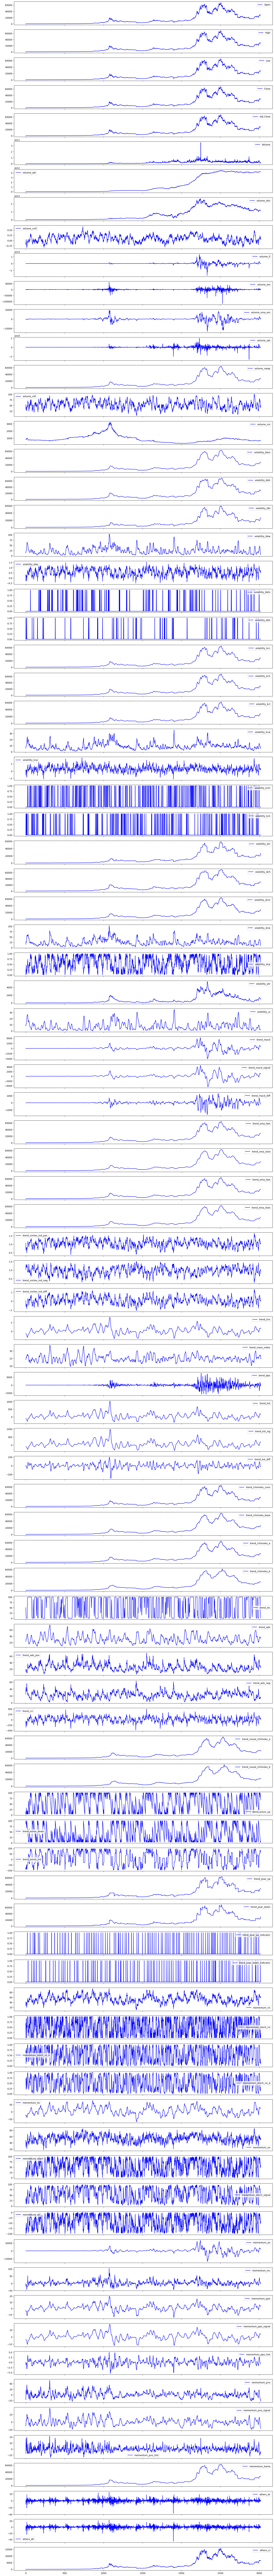

In [5]:
ta_df.plot(subplots=True, color='blue', figsize=(20, 200));

## 4. Correlation

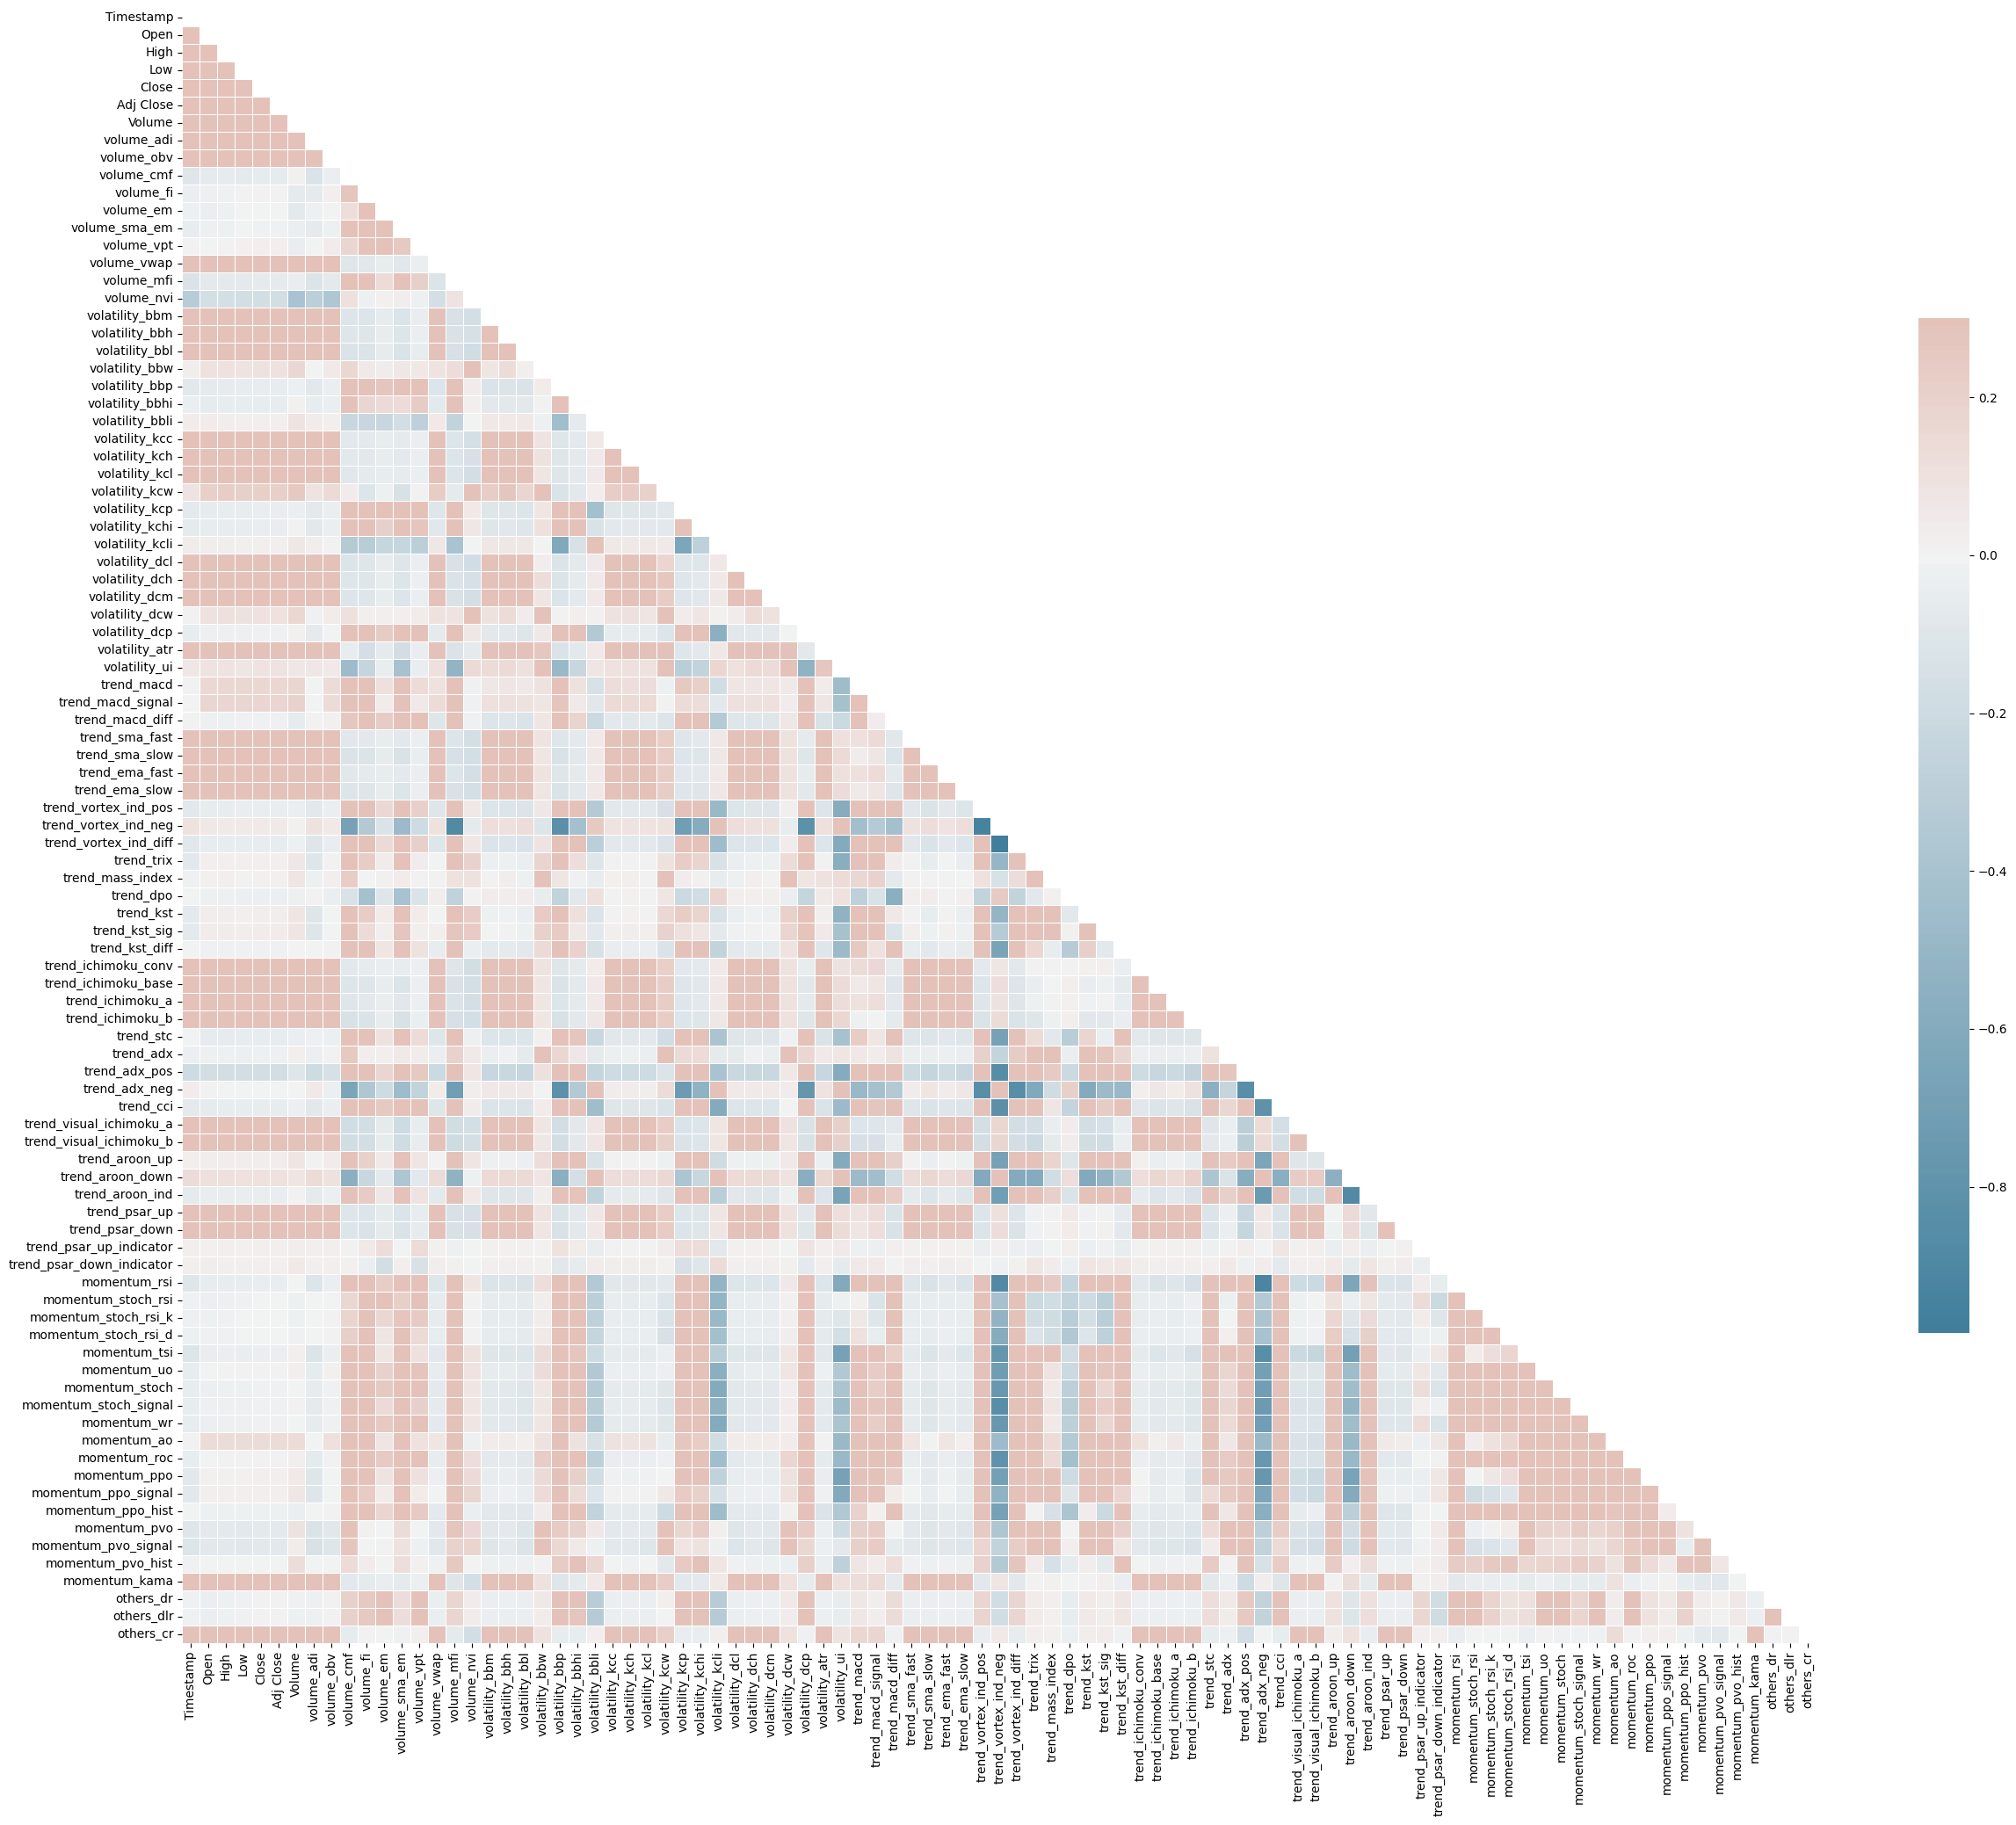

In [54]:
# Compute the correlation matrix
corr = ta_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show the plot
plt.show()

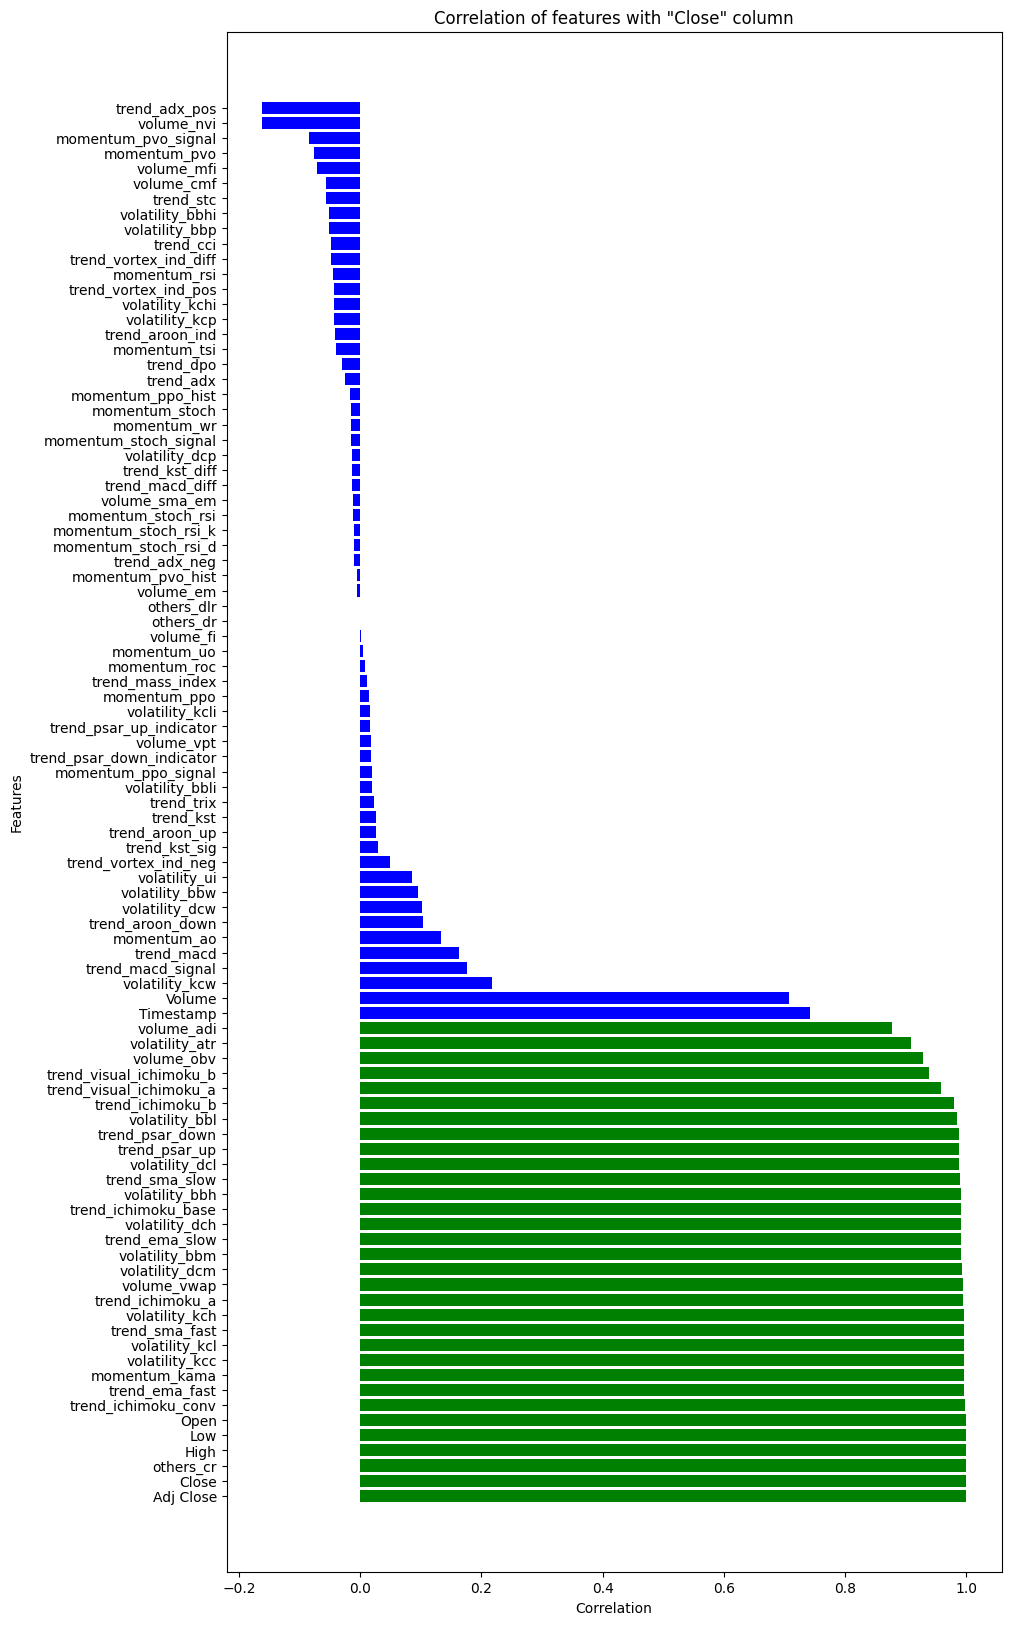

In [47]:
# Compute the correlation matrix
corr_matrix = ta_df.corr()

# Get the correlations of 'Close' with all other variables
close_corr = corr_matrix['Close']

# Sort the correlations in descending order
sorted_corr = close_corr.sort_values(ascending=False)

colors = np.where(sorted_corr.abs() > 0.8, 'g', 'b')

# Plot the sorted correlations as a horizontal bar chart
plt.figure(figsize=(10,20))
plt.barh(sorted_corr.index, sorted_corr, color=colors)
plt.title('Correlation of features with "Close" column')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()

In [35]:
#count_0 = ta_df['Direction'].value_counts().get(0)
#count_1 = ta_df['Direction'].value_counts().get(1)

#print(f"Count of 0s: {count_0}")
#print(f"Count of 1s: {count_1}")

Count of 0s: 1405
Count of 1s: 1614


## 5. Scale Data

In [55]:

scaler = MinMaxScaler(feature_range = (0, 1))
scaled_df = pd.DataFrame(scaler.fit_transform(ta_df.drop('Timestamp', axis=1)), columns=ta_df.columns[1:])


## 6. Prepare Training Sequences and Test Split

In [56]:
def create_sequences(data, seq_length):
    Xs, ys = [], []
    for i in range(len(data)-seq_length-1):  # -1 because we need the next day's price
        Xs.append(data.iloc[i:(i+seq_length)].values)
        # Calculate the direction of the price movement
        ys.append(int(data.iloc[i+seq_length+1]['Close'] > data.iloc[i+seq_length]['Close']))
    return np.array(Xs), np.array(ys)

# Create sequences with 60 time steps
X, y = create_sequences(scaled_df, 60)

# Split the data into training and test sets
split_index = int(X.shape[0]*0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

## 7. Model

In [57]:
from keras.layers import Bidirectional
# Define the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid function to output the probabilities for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/15
60/60 [==============================] - 10s 74ms/step - loss: 0.6948 - accuracy: 0.5203 - val_loss: 0.7119 - val_accuracy: 0.4641
Epoch 2/15
60/60 [==============================] - 4s 61ms/step - loss: 0.6860 - accuracy: 0.5452 - val_loss: 0.7090 - val_accuracy: 0.4831
Epoch 3/15
60/60 [==============================] - 4s 61ms/step - loss: 0.6865 - accuracy: 0.5441 - val_loss: 0.7168 - val_accuracy: 0.4810
Epoch 4/15
60/60 [==============================] - 4s 61ms/step - loss: 0.6849 - accuracy: 0.5647 - val_loss: 0.7160 - val_accuracy: 0.4916
Epoch 5/15
60/60 [==============================] - 4s 61ms/step - loss: 0.6872 - accuracy: 0.5473 - val_loss: 0.7248 - val_accuracy: 0.4705
Epoch 6/15
60/60 [==============================] - 4s 61ms/step - loss: 0.6853 - accuracy: 0.5552 - val_loss: 0.7252 - val_accuracy: 0.4768
Epoch 7/15
60/60 [==============================] - 4s 62ms/step - loss: 0.6860 - accuracy: 0.5547 - val_loss: 0.7250 - val_accuracy: 0.4726
Epoch 8/15
6

## 8. Testing the Model

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from keras.utils.vis_utils import plot_model

# Use the model to make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predictions to binary format
y_pred = (y_pred > 0.5).astype(int)

# Print the accuracy of the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Print the ROC AUC score of the model
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")

# Print the confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

# Print the classification report
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

# plot model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


19/19 [==============================] - 2s 18ms/step
Accuracy: 0.518581081081081
ROC AUC Score: 0.5
Confusion Matrix: 
[[307   0]
 [285   0]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       307
           1       0.00      0.00      0.00       285

    accuracy                           0.52       592
   macro avg       0.26      0.50      0.34       592
weighted avg       0.27      0.52      0.35       592

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print(X_train)


[[[2.13050245e-03 1.58511714e-03 2.15211912e-03 ... 5.65764509e-01
   6.46506435e-01 2.02030823e-03]
  [2.03616194e-03 1.51809832e-03 2.14550403e-03 ... 5.99498301e-01
   6.77276776e-01 2.03192768e-03]
  [2.04754632e-03 1.50805143e-03 1.65490246e-03 ... 4.22849154e-01
   5.08375445e-01 1.52813403e-03]
  ...
  [8.83724129e-04 6.55050912e-04 9.80599127e-04 ... 7.13430524e-01
   7.76621721e-01 1.12370439e-03]
  [1.13729812e-03 6.26455487e-04 1.17759188e-03 ... 5.98251886e-01
   6.76151401e-01 1.13015943e-03]
  [1.14862317e-03 7.28062617e-04 1.12403539e-03 ... 6.32928405e-01
   7.07139035e-01 1.21828984e-03]]

 [[2.03616194e-03 1.51809832e-03 2.14550403e-03 ... 5.99498301e-01
   6.77276776e-01 2.03192768e-03]
  [2.04754632e-03 1.50805143e-03 1.65490246e-03 ... 4.22849154e-01
   5.08375445e-01 1.52813403e-03]
  [1.54734455e-03 1.10092340e-03 1.30042722e-03 ... 4.99252305e-01
   5.83854072e-01 1.27754324e-03]
  ...
  [1.13729812e-03 6.26455487e-04 1.17759188e-03 ... 5.98251886e-01
   6.76151

## Bayesian Optimisation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

# Read dataset
df = pd.read_csv('bitcoin-ta-2015.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

def create_model(params):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=int(params['units']), return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(params['dropout']))
    model.add(Bidirectional(LSTM(units=int(params['units']), return_sequences=False)))
    model.add(Dense(25))
    model.add(Dense(1))
    return model

def objective(params):
    model = create_model(params)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mean_squared_error')

    # Train the model
    model.fit(params['X_train'], params['y_train'], epochs=int(params['epochs']), batch_size=int(params['batch_size']), validation_split=0.2, verbose=0)


    # Validation
    test_data = scaler.transform(params['test'])
    X_test = []
    y_test = []  # Initialize y_test as empty list

    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i, :])  # Appending X_test
        y_test.append(params['test'].iloc[i]['Close'])  # Append corresponding y_test

    y_test = np.array(y_test)  # Convert y_test to numpy array


    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    # Check the model's prediction
    predictions = model.predict(X_test)

    price_scaler = MinMaxScaler(feature_range=(0,1))
    price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

    # Now you can inverse_transform your predictions
    predictions = price_scaler.inverse_transform(predictions)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, predictions)

    return {'loss': mse, 'status': STATUS_OK}

# Hyperparameters space
space = {
    'units': hp.quniform('units', 50, 200, 1),
    'dropout': hp.uniform('dropout', 0.0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'epochs': hp.quniform('epochs', 20, 50, 10),
    'batch_size': hp.quniform('batch_size', 10, 100, 1),
    'X_train': X_train,
    'y_train': y_train,
    'test': test
}

# Trials object to store the optimization history
trials = Trials()

# Run the algorithm
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)
